In [1]:
import pandas as pd
import urllib
import numpy as np
import os
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

import utils

## Downloading dataset

In [2]:
df = utils.download_data(filename='dataset.csv')
df

dataset.csv already exists in the current directory.


,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL63786,3.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.28910,True
1,CHEMBL35820,6.000000e-03,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.93330,True
2,CHEMBL53711,6.000000e-03,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.59690,True
3,CHEMBL66031,8.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.01220,True
4,CHEMBL53753,8.000000e-03,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.57260,True
...,...,...,...,...,...,...,...,...,...,...
4630,CHEMBL120564,2.600000e+06,nM,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,214.074228,4,1,2.13978,True
4631,CHEMBL66879,3.000000e+06,nM,O=C(O)/C=C/c1ccc(O)cc1,2.522879,164.047344,2,2,1.49000,True
4632,CHEMBL261238,5.000000e+06,nM,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,404.095250,6,1,5.20048,True
4633,CHEMBL76587,6.500000e+06,nM,N#CC(C#N)Cc1ccc(O)cc1,2.187087,172.063663,3,1,1.59806,True


In [3]:
df = df[["smiles", "pIC50"]]
# Add column for activity
df["active"] = np.zeros(len(df))

# Mark every molecule as active with an pIC50 of >= 8.0, 0 otherwise
pIC50_cut_off = 8.0
df.loc[df[df.pIC50 >= pIC50_cut_off].index, "active"] = 1.0
df

,smiles,pIC50,active
0,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,1.0
1,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,1.0
2,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,1.0
3,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,1.0
4,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,1.0
...,...,...,...
4630,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,0.0
4631,O=C(O)/C=C/c1ccc(O)cc1,2.522879,0.0
4632,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,0.0
4633,N#CC(C#N)Cc1ccc(O)cc1,2.187087,0.0


## Features

In [4]:
df["finger print"] = df["smiles"].apply(utils.smiles_to_descriptors, type='morgan2')
df["selfies"] = df["smiles"].apply(utils.smiles_to_descriptors, type='selfies')


df

,smiles,pIC50,active,finger print,selfies
0,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Br][C][=C][C][=C][C][Branch2][Ring1][=Branch1...
1,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][C][O][C][=C][C][=N][C][=N][C][Branch1][=N]...
2,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",[C][N][Branch1][C][C][C][=C][C][=C][Branch1][=...
3,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Br][C][=C][C][=C][C][Branch2][Ring1][Branch1]...
4,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",[C][N][C][=C][C][=C][Branch1][=N][N][C][=C][C]...
...,...,...,...,...,...
4630,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][O][C][=C][C][Branch1][=Branch2][C][=C][Bra...
4631,O=C(O)/C=C/c1ccc(O)cc1,2.522879,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[O][=C][Branch1][C][O][/C][=C][/C][=C][C][=C][...
4632,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",[C][N][Branch1][=Branch2][C][=C][C][=C][N][=C]...
4633,N#CC(C#N)Cc1ccc(O)cc1,2.187087,0.0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[N][#C][C][Branch1][Ring1][C][#N][C][C][=C][C]...


### RNN model features

In [5]:
# Mordred takes forever to run, so just loading the pickled file!
morderd_file = 'mordred_descriptors.pkl'
if not os.path.exists(morderd_file):
    df['mordred'] = df["smiles"].apply(utils.smiles_to_descriptors, type='mordred')
else:
    df['mordred'] = pd.read_pickle('mordred_descriptors.pkl')
mordred_array = np.array([list(array[0]) for array in df['mordred']])

# Identify columns with NaN values
nan_columns = np.isnan(mordred_array).any(axis=0)
# Extract columns without NaN values
mordred_array_without_nan = mordred_array[:, ~nan_columns]

# dropping features with 0 std
mask = mordred_array_without_nan.std(axis=0) != 0
mordred_array_without_nan = mordred_array_without_nan[:, mask]

Creating an integer encoding for the selfies by tokenizing them:

In [6]:
import selfies as sf
alphabet = sf.get_alphabet_from_selfies(df['selfies'].to_list())
alphabet.add('[nop]') # This is a special padding symbol
alphabet.add('.')
alphabet = list(sorted(alphabet))
voc = {s: i for i, s in enumerate(alphabet)}
pad_to_len = max(sf.len_selfies(s) for s in df["selfies"])
voc['[nop]'] = 0 # This will be masked in the trainable embedding layer
voc['.'] = 58
df['encoding'] = df["selfies"].apply(utils.selfies_to_encoding, vocab_stoi=voc, pad_to_len=pad_to_len)
voc

{'.': 58,
 '[#Branch1]': 1,
 '[#Branch2]': 2,
 '[#C]': 3,
 '[#N]': 4,
 '[/C@@H1]': 5,
 '[/C@H1]': 6,
 '[/C]': 7,
 '[/Cl]': 8,
 '[/F]': 9,
 '[/N+1]': 10,
 '[/N]': 11,
 '[/O]': 12,
 '[=Branch1]': 13,
 '[=Branch2]': 14,
 '[=C]': 15,
 '[=N+1]': 16,
 '[=N-1]': 17,
 '[=N]': 18,
 '[=O+1]': 19,
 '[=O]': 20,
 '[=P]': 21,
 '[=Ring1]': 22,
 '[=Ring2]': 23,
 '[=S]': 24,
 '[B]': 25,
 '[Br-1]': 26,
 '[Br]': 27,
 '[Branch1]': 28,
 '[Branch2]': 29,
 '[C@@H1]': 30,
 '[C@@]': 31,
 '[C@H1]': 32,
 '[C@]': 33,
 '[C]': 34,
 '[Cl-1]': 35,
 '[Cl]': 36,
 '[F]': 37,
 '[I]': 38,
 '[N+1]': 39,
 '[NH1]': 40,
 '[N]': 41,
 '[O-1]': 42,
 '[OH0]': 43,
 '[O]': 44,
 '[P]': 45,
 '[Ring1]': 46,
 '[Ring2]': 47,
 '[S+1]': 48,
 '[S]': 49,
 '[Se]': 50,
 '[Si]': 51,
 '[Zn+2]': 52,
 '[\\C]': 53,
 '[\\F]': 54,
 '[\\N]': 55,
 '[\\O]': 56,
 '[\\S]': 57,
 '[nop]': 0}

## Train, Validation Test Splits

In [68]:
from sklearn.model_selection import KFold, train_test_split

SEED = 10

X = np.vstack(df['finger print'])
y = np.vstack(df['active'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Second split: Split into half for validation and test sets (i.e., 10% each of original data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=SEED)

splits = [X_train, X_val, y_train, y_val]

print(f"Training size: {len(X_train)}")
print(f"Val size: {len(y_val)}")
print(f"Test size: {len(y_test)}")

Training size: 3708
Val size: 463
Test size: 464


## Baseline Models

### Random Forest Classifier

In [69]:
from sklearn.ensemble import RandomForestClassifier
# Set model parameter for random forest
param = {
    "n_estimators": 50,  # number of trees to grows
    "criterion": "entropy",  # loss function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [70]:
# Fit model on single split
performance_measures = utils.model_training_and_validation(model_RF, "RF", splits)

Accuracy: 0.86
AUC: 0.88
f1 score: 0.60


### Logistic Regression

In [71]:
from sklearn.linear_model import LogisticRegression
# Specify model
model_lr = LogisticRegression(max_iter=2000)
# Fit model on single split
performance_measures = utils.model_training_and_validation(model_lr, "LR", splits)

Accuracy: 0.86
AUC: 0.88
f1 score: 0.60


### RNN

In [72]:
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import tensorflow as tf
from dataclasses import dataclass


X_e = np.vstack(df['encoding'])
X_= np.vstack(df['finger print'])
# X_m = np.vstack(df['other desc'])
X_m = mordred_array_without_nan
X = np.concatenate([X_e, X_,X_m],axis=1)


y = np.vstack(df['active'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Second split: Split into half for validation and test sets (i.e., 10% each of original data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=SEED)


# from imblearn.over_sampling import SMOTE

# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X_train,y_train)

# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X_train,y_train)

splits = [X_train, X_val, y_train, y_val]

print(f"Training size: {len(X_train)}")
print(f"Val size: {len(y_val)}")
print(f"Test size: {len(y_test)}")

Training size: 3708
Val size: 463
Test size: 464


In [127]:
import tensorflow as tf
from dataclasses import dataclass
from tensorflow.keras.callbacks import ReduceLROnPlateau

class RNNModel(tf.keras.Model):
    def __init__(self, config, input_shapes, output_bias=None, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.config = config
        self.l, self.f, self.m  = input_shapes
        # self.f = f
        # self.m = m
        self.output_bias = output_bias
        self.model = self.build_LSTM_model()

    def build_LSTM_model(self):
        tf.keras.backend.clear_session()
        input = tf.keras.Input(shape=(self.l,))
        input_f = tf.keras.Input(shape=(self.f,))
        # input_f = tf.keras.layers.Reshape((self.f,1))(input_f)
        input_m = tf.keras.Input(shape=(self.m,))

        e = tf.keras.layers.Embedding(
            input_dim=self.config.vocab_size,
            output_dim=self.config.embedding_dim,
            mask_zero=True)(input)
        
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.config.rnn_units, activation=None))(e)
        x = tf.keras.layers.LayerNormalization()(x)
        # x_f = tf.keras.layers.Conv1D(filters=self.config.cnn_filter, 
        #            kernel_size=self.config.cnn_kernel_size, 
        #            activation='relu')(input_f)
        # x_f =  tf.keras.layers.LayerNormalization()(x_f)
        # x_f = tf.keras.layers.Dropout(self.config.drop_rate)(x_f)    
        # x_f = tf.keras.layers.MaxPooling1D(pool_size=self.config.pool_size)(x_f)
        # x_f = tf.keras.layers.Flatten()(x_f)
        
        x = tf.keras.layers.Concatenate()([x, input_f]) # input_f
        x = tf.keras.layers.Dropout(self.config.drop_rate)(x)
        
        x = tf.keras.layers.Dense(
            self.config.hidden_dim,
            # activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(self.config.reg_strength))(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Concatenate(axis=1)([x, input_m])
        x = tf.keras.layers.Dense(
            self.config.hidden_dim//2,
            activation='swish',
            kernel_regularizer=tf.keras.regularizers.l2(self.config.reg_strength))(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(self.config.drop_rate)(x)
        
        x = tf.keras.layers.Dense(
            self.config.hidden_dim // 8,
            activation='swish',
            kernel_regularizer=tf.keras.regularizers.l2(self.config.reg_strength))(x)
        x = tf.keras.layers.LayerNormalization()(x)
        
        output = tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=None)(x)

        return tf.keras.Model(inputs=[input, input_f, input_m], outputs=output, name='LSTM')

    def compile(self):
        opt = tf.optimizers.Adam(self.config.lr)
        self.model.compile(
            opt,
            loss= tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5),
                     tf.keras.metrics.AUC(from_logits=False),
                    tf.keras.metrics.F1Score(threshold=0.5)]) 

    def train(self, X_train_input, X_train_input_f, X_train_input_m,
              y_train, X_test_input, X_test_input_f, X_test_input_m, y_test, verbose=1):
        self.compile()
        reduce_lr = ReduceLROnPlateau(monitor='val_auc',
                                      factor=0.9,
                                      patience=8,
                                      min_lr=0.00001,
                                      )
        
        self.result = self.model.fit(
            [X_train_input, X_train_input_f, X_train_input_m], y_train,
            validation_data=([X_test_input, X_test_input_f, X_test_input_m], y_test),
            callbacks=[reduce_lr, 
                       tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', 
                                                        restore_best_weights=True, patience=self.config.early_stopping_patience)],
            epochs=self.config.epochs, batch_size=self.config.batch_size, verbose=verbose)

    def evaluate(self, x, y, **kwargs):
        """Evaluate the model on the provided data."""
        return self.model.evaluate(x, y, **kwargs)
        
    def summary(self):
        """Prints a summary representation of the keras model."""
        self.model.summary()

# Example usage:
# rnn_model = RNNModel(lstm_config, L)
# rnn_model.compile()
# rnn_model.train(X_train_input, X_train_input_f, X_train_input_m, y_train, X_test_input, X_test_input_f, X_test_input_m, y_test)

In [133]:
@dataclass
class LSTM_Config:
    vocab_size: int = len(voc)
    batch_size: int = 16
    buffer_size: int = 10000
    rnn_units: int = 32
    hidden_dim: int = 64
    embedding_dim: int = 8
    reg_strength: float = 0
    lr: float = 1e-2
    drop_rate: float = 0.2
    epochs: int = 100
    nmodels: int = 1
    adv_epsilon: float = 1e-3
    early_stopping_patience = 5
    cnn_filter = 16
    cnn_kernel_size = 5
    cnn_units = 16
    pool_size = 10
    

lstm_config = LSTM_Config()

In [134]:
from sklearn.preprocessing import StandardScaler

def prepare_RNN_data(X_train, X_val, X_test, j, k, selected_feature_indices=None):
    """
    Prepares data by slicing and scaling.

    Parameters:
    - X_train, X_val, X_test: input datasets
    - j, k: indices for slicing
    - selected_feature_indices (optional): indices for feature selection. If None, all are considered.

    Returns:
    Sliced and scaled datasets.
    """
    
    # Slicing
    X_train_input_f = X_train[:, -j:-k]
    X_val_input_f = X_val[:, -j:-k]
    X_test_input_f = X_test[:, -j:-k]

    # If selected_feature_indices is None, consider all columns in the range
    if selected_feature_indices is None:
        X_train_input_m = X_train[:, -k:]
        X_val_input_m = X_val[:, -k:]
        X_test_input_m = X_test[:, -k:]
    else:
        X_train_input_m = X_train[:, -k:][:, selected_feature_indices]
        X_val_input_m = X_val[:, -k:][:, selected_feature_indices]
        X_test_input_m = X_test[:, -k:][:, selected_feature_indices]

    # Scaling
    scaler = StandardScaler().fit(X_train_input_m)
    X_train_input_m = scaler.transform(X_train_input_m) 
    X_val_input_m = scaler.transform(X_val_input_m) 
    X_test_input_m = scaler.transform(X_test_input_m)

    X_train_input = X_train[:, :-j]
    X_val_input = X_val[:, :-j]
    X_test_input = X_test[:, :-j]

    return (X_train_input, X_train_input_f, X_train_input_m, 
            X_val_input, X_val_input_f, X_val_input_m,
            X_test_input, X_test_input_f, X_test_input_m)

# Example usage:
# X_train_input, X_train_input_f, X_train_input_m, X_val_input, X_val_input_f, X_val_input_m, X_test_input, X_test_input


# [25, 114, 125, 126, 127, 129, 132, 134, 135, 136, 137, 138, 142, 145, 148, 151, 154, 155,
#          158, 160, 163, 165, 167, 169, 170, 171, 172, 176, 178, 180, 185, 189, 190, 192, 194, 196,
#          198, 199, 203, 205, 206, 207, 208, 210, 220, 221, 260, 261, 264, 316, 340, 343, 349, 350,
#          354, 358, 386, 387, 389, 400, 404, 410, 417, 423, 428, 429, 431, 433, 434, 441, 445, 452,
#          455, 459, 462, 464, 468, 469, 470, 471, 472, 473, 474, 489, 490, 491, 492, 493, 494, 495,
#          496, 600, 606, 609, 613, 616, 617, 618, 620, 623] 0.92

In [135]:
selected_feature_indices = [26, 27, 48, 55, 72, 124, 125, 126, 127, 129, 132, 133, 135, 136, 137, 138, 142, 143,
         144, 145, 147, 148, 150, 151, 153, 154, 155, 156, 158, 160, 163, 164, 165, 167, 168, 169,
         170, 171, 172, 173, 174, 176, 177, 179, 180, 181, 185, 186, 188, 190, 192, 193, 194, 196,
         197, 199, 200, 201, 203, 204, 206, 207, 209, 210, 211, 220, 251, 260, 261, 263, 265, 270,
         271, 272, 295, 316, 343, 344, 349, 350, 354, 358, 386, 387, 399, 409, 410, 416, 417, 418,
         423, 426, 428, 429, 431, 433, 434, 441, 445, 452, 455, 459, 464, 468, 469, 470, 471, 472,
         473, 474, 488, 489, 491, 492, 493, 494, 495, 496, 514, 527, 600, 602, 603, 612, 613, 616,
         617, 618, 623, 638] 

# selected_feature_indices = [ 12, 203, 298, 312, 316, 340, 354, 358, 387, 388, 444, 455, 503,
#        514, 523, 527, 556, 565, 572, 578]



j = X_train.shape[1]- len(df['encoding'].iloc[0])
k = mordred_array_without_nan.shape[1]

X_train_input, X_train_input_f, X_train_input_m, \
X_val_input, X_val_input_f, X_val_input_m, \
X_test_input, X_test_input_f, X_test_input_m = prepare_RNN_data(
    X_train, X_val, X_test, j, k, selected_feature_indices)

In [136]:
# from sklearn.preprocessing import StandardScaler


# j = X_train.shape[1]- len(df['encoding'].iloc[0])
# print(j)
#  # k = len(df['other desc'].iloc[0])
# k = mordred_array_without_nan.shape[1]
# print(k)

# selected_feature_indices = [ 12, 203, 298, 312, 316, 340, 354, 358, 387, 388, 444, 455, 503,
#        514, 523, 527, 556, 565, 572, 578]

# X_train_input_f = X_train[:, -j:-k]
# X_val_input_f = X_val[:, -j:-k]
# X_test_input_f = X_test[:, -j:-k]
# X_train_input_m = X_train[:, -k:][:, selected_feature_indices]
# X_val_input_m = X_val[:, -k:][:, selected_feature_indices]
# X_test_input_m = X_test[:, -k:][:, selected_feature_indices]

# scaler = StandardScaler().fit(X_train_input_m)
# X_train_input_m = scaler.transform(X_train_input_m) 
# X_test_input_m = scaler.transform(X_test_input_m) 
# X_val_input_m = scaler.transform(X_val_input_m) 


# X_train_input = X_train[:, :-j]
# X_test_input = X_test[:, :-j]
# X_val_input = X_val[:, :-j]

In [137]:
input_shapes = [X_train_input.shape[1], X_train_input_f.shape[1], X_train_input_m.shape[1]]
rnn_model = RNNModel(lstm_config, input_shapes)
rnn_model.summary()

Model: "LSTM"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 87)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 87, 8)                472       ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 64)                   10496     ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 layer_normalization (Layer  (None, 64)                   128       ['bidirectional[0][0]']    

In [138]:
result = rnn_model.train(X_train_input, X_train_input_f, X_train_input_m,
                y_train, X_val_input, X_val_input_f, X_val_input_m, y_val, verbose=1)

Epoch 1/100
232/232 [==============================] - 44s 131ms/step - loss: 0.4309 - binary_accuracy: 0.8069 - auc: 0.7524 - f1_score: 0.2166 - val_loss: 0.4182 - val_binary_accuracy: 0.8359 - val_auc: 0.7792 - val_f1_score: 0.3968 - lr: 0.0100
Epoch 2/100
232/232 [==============================] - 26s 112ms/step - loss: 0.3515 - binary_accuracy: 0.8314 - auc: 0.8577 - f1_score: 0.4881 - val_loss: 0.3703 - val_binary_accuracy: 0.8445 - val_auc: 0.8204 - val_f1_score: 0.4627 - lr: 0.0100
Epoch 3/100
232/232 [==============================] - 27s 116ms/step - loss: 0.3198 - binary_accuracy: 0.8595 - auc: 0.8868 - f1_score: 0.5901 - val_loss: 0.3915 - val_binary_accuracy: 0.8402 - val_auc: 0.8372 - val_f1_score: 0.5195 - lr: 0.0100
Epoch 4/100
232/232 [==============================] - 26s 114ms/step - loss: 0.3024 - binary_accuracy: 0.8665 - auc: 0.9005 - f1_score: 0.6336 - val_loss: 0.3493 - val_binary_accuracy: 0.8445 - val_auc: 0.8584 - val_f1_score: 0.5385 - lr: 0.0100
Epoch 5/100


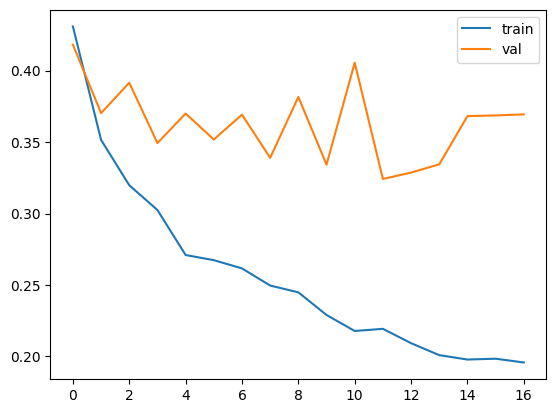

In [140]:
from matplotlib import pyplot as plt
plt.plot(rnn_model.result.history['loss'], label='train')
plt.plot(rnn_model.result.history['val_loss'], label='val')
plt.legend()

In [141]:
rnn_model.evaluate([X_test_input, X_test_input_f, X_test_input_m], y_test)

15/15 [==============================] - 1s 34ms/step - loss: 0.2865 - binary_accuracy: 0.8793 - auc: 0.9198 - f1_score: 0.6782


[0.2864706516265869,
 0.8793103694915771,
 0.919775128364563,
 array([0.6781609], dtype=float32)]

In [ ]:
# rnn_model.result.history

In [206]:
from tqdm import tqdm
from sklearn import clone
def base_model_crossvalidation(ml_model,df, X_columns, y_columns, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    f1_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in tqdm(kf.split(df)):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = np.vstack(df[X_columns].iloc[train_index])
        train_y = np.vstack(df[y_columns].iloc[train_index])


        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = np.vstack(df[X_columns].iloc[test_index])
        test_y = np.vstack(df[y_columns].iloc[test_index])

        # Performance for each fold
        accuracy, auc, f1 = utils.model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        auc_per_fold.append(auc)
        f1_per_fold.append(f1)

    # Print statistics of results
    print(
        f"ACC:\t {np.mean(acc_per_fold):.2f}"
        f" ± {np.std(acc_per_fold):.2f} \n"
        f"AUC:\t {np.mean(auc_per_fold):.2f}"
        f" ± {np.std(auc_per_fold):.2f} \n"
        f"F1:\t {np.mean(f1_per_fold):.2f}"
        f" ± {np.std(f1_per_fold):.2f} \n"
    )
    results_dict = {
        'ACC': {
            'mean': f"{np.mean(acc_per_fold):.3g}",
            'std': f"{np.std(acc_per_fold):.3g}"
        },
        'AUC': {
            'mean': f"{np.mean(auc_per_fold):.3g}",
            'std': f"{np.std(auc_per_fold):.3g}"
        },
        'F1': {
            'mean': f"{np.mean(f1_per_fold):.3g}",
            'std': f"{np.std(f1_per_fold):.3g}"
        }
    }
    return results_dict



In [207]:
param = {
    "n_estimators": 50,  # number of trees to grows
    "criterion": "entropy",  # loss function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

base_line_cv = base_model_crossvalidation(model_RF, df, X_columns='finger print', y_columns='active')
base_line_cv

5it [00:20,  4.19s/it]

ACC:	 0.87 ± 0.01 
AUC:	 0.90 ± 0.01 
F1:	 0.61 ± 0.02 



{'ACC': {'mean': '0.866', 'std': '0.0111'},
 'AUC': {'mean': '0.903', 'std': '0.0125'},
 'F1': {'mean': '0.61', 'std': '0.0201'}}